# Project Goal

The goal of this project is to predict housing prices from the ['Ames Housing Dataset'](http://www.amstat.org/publications/jse/v19n3/decock.pdf), involving 79 explanatory variables including continuous, categorical and ordinal data types.

The dataset is part of the ['Housing Prices: Advanced Regression Techniques'](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition hosted by Kaggle. Scores are assessed via RMSLE and ranked on the leaderboard.

This notebook will discuss the process and results for the initial data exploration, missing value imputation, feature engineering, feature selection, and regression modelling. The models used to fit the data include Ridge, Lasso, Elastic Net and Gradient Boosting (XGBoost).

By comparing standardized elastic net coefficients the most important categorical features for high sale price were related to neighborhood, zoning type, and home functionality. The most important numerical features were related to property age and size.

The RMLSE achieved by the top performing Elastic Net model is 0.11501, placing it in the top 7% of scores as of January 2019. 

# Initial Data Exploration

Import the modules we will be using for this project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import utils
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

Load the train and test data

In [2]:
pd.options.mode.chained_assignment = None # remove dataframe copy warning messages

data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Initial data exploration reveals there are 38 numeric type features, and 43 non-numeric features.
The total number of rows is 1460, however the counts for many columns is less than 1460, indicating missing values.
Some features such as 'PoolQC' and 'MiscFeature' have a majority of missing values.

'SalePrice' is the target variable we are trying to predict.

In [3]:
pd.set_option('display.max_columns', None)
# print(data.describe(include='all'))
print('Total data dimensions', data.shape)
print('Data dimensions of numeric features', data.select_dtypes(include=[np.number]).shape)

Total data dimensions (1460, 81)
Data dimensions of numeric features (1460, 38)


The 'Id' column is a unique identifier for each row of data, and does not have any predictive power. We can safely remove these columns.

In [4]:
test_id = test['Id'] 
data = data.drop(columns=['Id'])
test = test.drop(columns=['Id'])

We can check for features with only one unique value, indicating the feature will have no predictive power. As there is no output, all features have more than one unique value.

In [5]:
count = 0

for column in data:
    if len(data[column].unique()) <= 1:
        count += 1
        print(column)
if count == 0: 
    print('No columns with one unique value found')

No columns with one unique value found


# Feature Correlation

Pearson correlations between numerical variables can be calculated where zero represents no correlation. +1.0 indicates perfect positive correlation, 0 represents no correlation, and -1.0 indicates perfect negative correlation.

The most correlated numerical features with 'SalePrice' are 'OverallQual' - The overall quality of the property on an ordinal 1-10 scale, and 'GrLivArea' the area of the living spaces above ground.


In [6]:
numeric_data = data.select_dtypes(include=[np.number])
correlations = numeric_data.corr()

idx = len(numeric_data.columns)

print(numeric_data.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()[1:7])


GarageCars   GarageArea      0.882475
YearBuilt    GarageYrBlt     0.825667
GrLivArea    TotRmsAbvGrd    0.825489
TotalBsmtSF  1stFlrSF        0.819530
SalePrice    OverallQual     0.790982
GrLivArea    SalePrice       0.708624
dtype: float64


When looking at correlations between features we see that several have corelation values > 0.8. Namely, ('GarageCars' and 'GarageArea'), ('GarageYrBlt' and 'YearBuilt'), ('GrLivArea' and 'TotRmsAbvGrd') and ('TotalBsmtSF' and '1stFlrSF'). The presence of collinearity can inflate the variance and cause instability in coefficient estimates, so we will remove one variable from each pair of collinear variables. 

Intuitively, the variables represent the same information, for example, the number of cars and the area of the garage are both giving the same information - the size of the garage. Therefore it is probably safe to remove one of these variables. While highly correlated, TotalBsmtSF and 1stFlrSF represent different features of the house, so we will keep both of these features for now.

In [7]:
data = data.drop(columns=['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd'])
test = test.drop(columns=['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd'])

# Outliers

By investigating the relationship of each feature with 'SalePrice' we can gain an idea of the distribution of the data, and the presence of any outliers. 

There appear to be several points, for example in the 'LotFrontage', and 'LotArea' feature plots, that lie very far from the main group of datapoints. We will plot these features in more detail in the next cell and explore these points further.

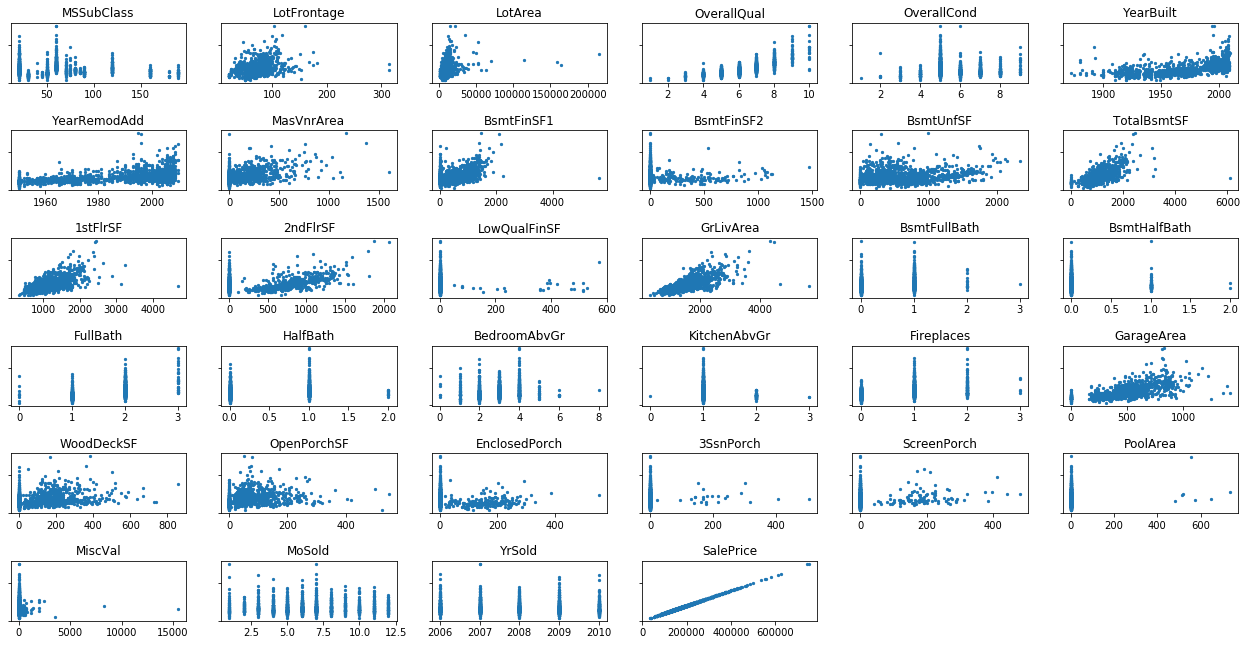

In [8]:
numeric_data = data.select_dtypes(include=[np.number])

%matplotlib inline
f, ax = plt.subplots(6, 6, figsize=(22,11))
for row in range(6):
    for col in range(6):
        idx = col+(6*row)
        if idx < 34:
            x = numeric_data.iloc[:, idx]
            y = numeric_data['SalePrice']
            ax[row, col].scatter(x, y, s=5)
            ax[row, col].set_title(numeric_data.columns[idx])
            ax[row, col].set_yticklabels([])
f.delaxes(ax[5, 4])
f.delaxes(ax[5, 5])
plt.subplots_adjust(hspace=0.8)
plt.show()

To identify possible outliers we can calculate the z-score for each feature. In general, a z-score of 3 or more is indicative of an outlier. Using this constraint on any feature yields many dozens of potential outliers. To constrain our outlier search we choose to identify outliers with z-score >= 5. To avoid information overload, we will look at just 6 continuous features that have high correlation with 'SalePrice'

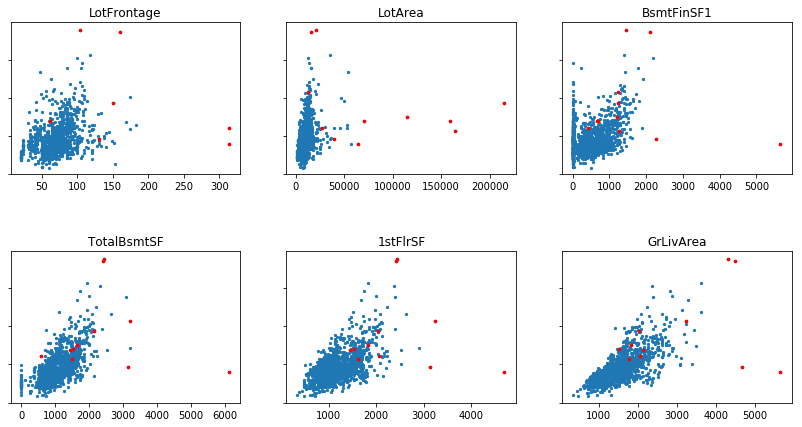

In [9]:
outlier_features = ['LotFrontage', 'LotArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea']
outlier_data = data.copy()

zscore_cols = []
# Calculate Z-score for each feature of interest
for col in outlier_features:
    col_zscore = col + '_zscore'
    zscore_cols += [col_zscore]
    outlier_data[col_zscore] = (outlier_data[col] - outlier_data[col].mean())/outlier_data[col].std(ddof=0)

# Get index values of points with z-score >= 5 for any feature
outlier_data = outlier_data[zscore_cols]
outliers = outlier_data[(outlier_data >= 5).any(axis=1)]
outliers_list = outliers.index.tolist()

pd.set_option('display.max_columns', 500)

# Add SalePrice for plotting convenience 
outlier_features += ['SalePrice']
data_only_outliers = data.iloc[outliers_list][outlier_features]
data_outliers = data[outlier_features]

f, ax = plt.subplots(2, 3, figsize=(14,7))
for row in range(3):
    for col in range(3):
        idx = col+(3*row)
        if idx < 6:
            x = data_outliers.iloc[:, idx]
            x_outlier = data_only_outliers.iloc[:, idx]
            y = data_outliers['SalePrice']
            y_outlier = data_only_outliers['SalePrice']
            ax[row, col].scatter(x, y, s=5)
            ax[row, col].scatter(x_outlier, y_outlier, s=7, c='r')
            ax[row, col].set_title(data_outliers.columns[idx])
            ax[row, col].set_yticklabels([])
plt.subplots_adjust(hspace=0.5)
plt.show()

The scatter plots show that an outlier for one particular feature may not necessarily be an outlier in another. Upon further investigation of the ['Ames Housing Dataset'](http://www.amstat.org/publications/jse/v19n3/decock.pdf) the author of the dataset reveals that there are three true outliers that involve partial sales. He suggests to drop datapoints with 'GrLivArea' > 4000.

After applying the suggested filter, we observe a tighter distribution in the six features, with the number of outliers decreasing from 11 to 8. While the remaining 8 points have a high z-score, without further information there is no reason to believe these are outliers, so we will keep these points in our dataset for now.

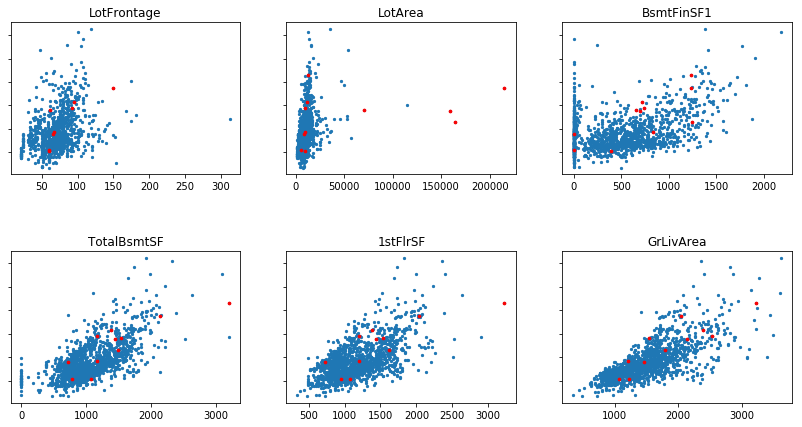

In [10]:
# Apply the filter ['GrLivArea'] < 4000
data = data[data['GrLivArea']<4000]

numeric_data = data.select_dtypes(include=[np.number])

# Re-plot outlier graphs
data_only_outliers = data.iloc[outliers_list][outlier_features]
data_outliers = data[outlier_features]

f, ax = plt.subplots(2, 3, figsize=(14,7))
for row in range(3):
    for col in range(3):
        idx = col+(3*row)
        if idx < 6:
            x = data_outliers.iloc[:, idx]
            x_outlier = data_only_outliers.iloc[:, idx]
            y = data_outliers['SalePrice']
            y_outlier = data_only_outliers['SalePrice']
            ax[row, col].scatter(x, y, s=5)
            ax[row, col].scatter(x_outlier, y_outlier, s=7, c='r') # outliers will appear red
            ax[row, col].set_title(data_outliers.columns[idx])
            ax[row, col].set_yticklabels([])
plt.subplots_adjust(hspace=0.5)
plt.show()

# Missing Values

Missing values must be imputed in order to retain the maximum information for model training.
Initial exploration of the data reveals missing data in both the train and test sets. Values will be imputed according to data type and number of missing values.

In [11]:
print('Train Set Missing Values')
print()
for col in data:
    num_missing = len(data) - data[col].count()
    if num_missing > 0:
        print(col, num_missing, str(round(num_missing/len(data)*100))+ '%')
print()
print('Test Set Missing Values')
print()
for col in test:
    num_missing = len(test) - test[col].count()
    if num_missing > 0:
        print(col, num_missing, str(round(num_missing/len(test)*100))+ '%')

Train Set Missing Values

LotFrontage 259 18.0%
Alley 1365 94.0%
MasVnrType 8 1.0%
MasVnrArea 8 1.0%
BsmtQual 37 3.0%
BsmtCond 37 3.0%
BsmtExposure 38 3.0%
BsmtFinType1 37 3.0%
BsmtFinType2 38 3.0%
Electrical 1 0.0%
FireplaceQu 690 47.0%
GarageType 81 6.0%
GarageFinish 81 6.0%
GarageQual 81 6.0%
GarageCond 81 6.0%
PoolQC 1451 100.0%
Fence 1176 81.0%
MiscFeature 1402 96.0%

Test Set Missing Values

MSZoning 4 0.0%
LotFrontage 227 16.0%
Alley 1352 93.0%
Utilities 2 0.0%
Exterior1st 1 0.0%
Exterior2nd 1 0.0%
MasVnrType 16 1.0%
MasVnrArea 15 1.0%
BsmtQual 44 3.0%
BsmtCond 45 3.0%
BsmtExposure 44 3.0%
BsmtFinType1 42 3.0%
BsmtFinSF1 1 0.0%
BsmtFinType2 42 3.0%
BsmtFinSF2 1 0.0%
BsmtUnfSF 1 0.0%
TotalBsmtSF 1 0.0%
BsmtFullBath 2 0.0%
BsmtHalfBath 2 0.0%
KitchenQual 1 0.0%
Functional 2 0.0%
FireplaceQu 730 50.0%
GarageType 76 5.0%
GarageFinish 78 5.0%
GarageArea 1 0.0%
GarageQual 78 5.0%
GarageCond 78 5.0%
PoolQC 1456 100.0%
Fence 1169 80.0%
MiscFeature 1408 97.0%
SaleType 1 0.0%


Upon inspection of the data, for most categorical features a missing value indicates that the feature is not present, rather than missing data. For example, 'PoolQC'= NA means the house does not have a pool, rather than there is missing data on the pool quality. For these data points we will replace NA with 'NotPresent'.

The remaining missing values in the categorical variables will be imputed with the mode value.

The missing values for continuous garage and basement values correspond to the non-presence of a garage or basement, therefore these values should be imputed as zero.

In [12]:
# NA means feature not prsent. Fill NA with not present
for feature in ['Alley', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
    data[feature] = data[feature].fillna('NotPresent')
    test[feature] = test[feature].fillna('NotPresent')
    
#For remaining categorical data impute with mode value
for feature in ['MasVnrType', 'Electrical', 'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']:
    value = data[feature].value_counts().keys()[0] # The key of value_counts() at index[0] is the mode value
    data[feature] = data[feature].fillna(value)
    test[feature] = test[feature].fillna(value)
    
#For MasVnrArea since the missing rows have MasVnrType as None, the Area should be zero
data['MasVnrArea'] = data['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)


#For BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath if there is no basment, these missing values should be zero
for feature in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    data.loc[data['BsmtFinType1'] == 'NotPresent', feature] = 0
    test.loc[test['BsmtFinType1'] == 'NotPresent', feature] = 0
    
#For GaragaArea if there is no garage the missing value should be zero
data.loc[data['GarageFinish'] == 'NotPresent', 'GarageArea'] = 0
test.loc[test['GarageFinish'] == 'NotPresent', 'GarageArea'] = 0
    

The proportion of missing values in 'LotFrontage' is 18%. This is much higher than for other continuous variables. 'LotFrontage' represents the linear feet of street connected to the property. 

From the correlation heatmap, the most correlated variables to 'LotFrontage' are 'LotArea' and '1stFlrSF'. Therefore we can use these two features and make a simple linear regression model to impute the values of 'LotFrontage' more accurately than using the a single descriptive statistic.

The residual plot shows two outliers, however the majority of points lie within the main cluster. Ignoring the outliers the cluster is fairly random, so this model is probably good enough to impute the missing values.

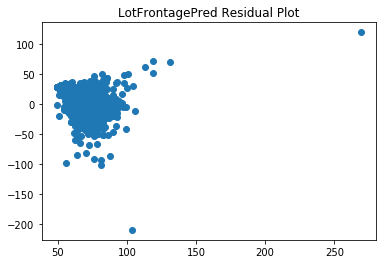

In [13]:
lotdata = data[['LotArea', '1stFlrSF', 'LotFrontage']]
lotdata = lotdata.dropna()

x = lotdata[['LotArea', '1stFlrSF']]
y = lotdata['LotFrontage']

y = y.values.reshape(-1, 1)
all_x = data[['LotArea', '1stFlrSF']]
test_all_x = test[['LotArea', '1stFlrSF']]

linear_lotfrontage = LinearRegression()
linear_lotfrontage.fit(x, y)

linear_pred = linear_lotfrontage.predict(all_x)
test_linear_pred = linear_lotfrontage.predict(test_all_x)

# Create a new column for predicted values
data['LotFrontagePred'] = linear_pred
test['LotFrontagePred'] = test_linear_pred

residuals_linear = data['LotFrontagePred'] - data['LotFrontage']

# Plot residuals
plt.scatter(data['LotFrontagePred'], residuals_linear)
plt.title('LotFrontagePred Residual Plot')
plt.show()

In [14]:
# Used predicted values column to fill the missing data
data['LotFrontage'] = data['LotFrontage'].fillna(data['LotFrontagePred'])
test['LotFrontage'] = test['LotFrontage'].fillna(test['LotFrontagePred'])

# Drop predicted value columns
data = data.drop(columns=['LotFrontagePred'])
test = test.drop(columns=['LotFrontagePred'])

# Baseline Model

Now that the missing values have been imputed we are able to create a baseline model. The test score of this model will be used for comparison with future models to quantify improvement. 

Log transformations will be discussed in the feature engineering, but for now we will simply apply a log1p transformation to the 'SalePrice' target variable so that the negative RMSE test metric will be in the same units as future examples.

For all categorical columns we will simpy dummy code without further processing.

After applying a simple OLS regression we obtain a cross validation score of -0.0156. By applying the predictions of this model to the Kaggle test set we obtain an RMLSE of 0.14048.

In [15]:
import warnings
warnings.filterwarnings("ignore")

baseline_data = data.copy()
baseline_test = test.copy()

# dummy code categorical columns
cat_data = data.select_dtypes(include=['object', 'category'])
cat_cols = cat_data.columns

dummy_df = pd.get_dummies(baseline_data[cat_cols])
test_dummy_df = pd.get_dummies(baseline_test[cat_cols])

baseline_data = pd.concat([baseline_data, dummy_df], axis=1)
baseline_test = pd.concat([baseline_test, test_dummy_df], axis=1)

baseline_data = baseline_data.drop(columns=cat_cols, axis=1)
baseline_test = baseline_test.drop(columns=cat_cols, axis=1)

# The train and test columns do not have the same levels so we create columns for missing levels to maintain dimensionality
missing_cols = set(baseline_data.columns) - set(baseline_test.columns)
for col in missing_cols:
    baseline_test[col] = 0

baseline_test = baseline_test[baseline_data.columns]
baseline_test = baseline_test.drop(columns=['SalePrice'])

Y = np.log1p(baseline_data['SalePrice'])
X = baseline_data.drop(columns=['SalePrice'])

lr = LinearRegression()
params = {}


grid = GridSearchCV(lr, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)
split_0_score = grid.cv_results_['split0_test_score']
split_1_score = grid.cv_results_['split1_test_score']
split_2_score = grid.cv_results_['split2_test_score']
split_3_score = grid.cv_results_['split3_test_score']
split_4_score = grid.cv_results_['split4_test_score']

print('Split0 Score', split_0_score) 
print('Split1 Score', split_1_score) 
print('Split2 Score', split_2_score) 
print('Split3 Score', split_3_score) 
print('Split4 Score', split_4_score)

# The Split1 Score appears to be an outlier, take the average of the four other splits to calculate mean score

print('Average score of splits [0, 2, 3, 4]:', np.mean(np.concatenate((split_0_score, split_2_score, split_3_score, split_4_score))))

Split0 Score [-0.01568995]
Split1 Score [-1.80120836e+09]
Split2 Score [-0.01962163]
Split3 Score [-0.01206376]
Split4 Score [-0.01518636]
Average score of splits 0, 2, 3, 4: -0.015640423864610075


# Feature Engineering

Domain knowledge is key to identifying and creating pertinent features in order to build an accurate model. Insights from housing valuation websites such as [Opendoor](https://www.opendoor.com/w/blog/factors-that-influence-home-value) give an insight from industry experts into what should be included in the model.

The eight most important factors from this blog include past prices, location, home size, age, condition and upgrades. While many of these factors are captured in the provided features, in order to provide the best model we will modify existing features and create new ones as required.

The total bathrooms of the property may be calculated by the addition of 'BsmtFullBath', 'FullBath', 'BsmtHalfBath' and 'HalfBath' features.

Likewise, the total livable square footage of the property may be calulcated by the addition of 'TotalBsmtSF' and 'GrLivArea'

In [16]:
data['TotalBaths'] = data['BsmtFullBath'] + data['FullBath'] + 0.5*(data['BsmtHalfBath'] + data['HalfBath'])
test['TotalBaths'] = test['BsmtFullBath'] + test['FullBath'] + 0.5*(test['BsmtHalfBath'] + test['HalfBath'])

data['TotalSF'] = data['TotalBsmtSF'] + data['GrLivArea']
test['TotalSF'] = test['TotalBsmtSF'] + test['GrLivArea']

data = data.drop(columns=['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath'])
test = test.drop(columns=['BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath'])

The 'MoSold' is a numeric data type column represents the month each property was sold. This column should be converted into categories. With investigation of the column it appears that the average 'SalePrice' depends on the time of the year. To capture this we can group the months into different seasons, represented by Q1, Q2, Q3 and Q4.

The 'MSSubClass' is another numeric data type column where each value represents a categorical code, so this column will also be converted into categories.

In [17]:
# Categorize MoSold
data = data.replace({'MoSold': {1: 'Q1', 2: 'Q1',3: 'Q1',
4: 'Q2',5: 'Q2',6: 'Q2',7: 'Q3',8: 'Q3',9: 'Q3',10: 'Q4',
11: 'Q4',12: 'Q4'}})

test = test.replace({'MoSold': {1: 'Q1', 2: 'Q1',3: 'Q1',
4: 'Q2',5: 'Q2',6: 'Q2',7: 'Q3',8: 'Q3',9: 'Q3',10: 'Q4',
11: 'Q4',12: 'Q4'}})

print(data.groupby(['MoSold'])['SalePrice'].mean())

# Categorize MSSubClass
data = data.replace({'MSSubClass': {20: 'class20', 30: 'class30',40: 'class40',
45: 'class45',50: 'class50',60: 'class60',70: 'class70',
75: 'class75',80: 'class80',85: 'class85',90: 'class90',
120: 'class120',150: 'class150',160: 'class160',180: 'class180',
190: 'class190'}})

test = test.replace({'MSSubClass': {20: 'class20', 30: 'class30',40: 'class40',
45: 'class45',50: 'class50',60: 'class60',70: 'class70',
75: 'class75',80: 'class80',85: 'class85',90: 'class90',
120: 'class120',150: 'class150',160: 'class160',180: 'class180',
190: 'class190'}})

MoSold
Q1    179386.182243
Q2    174270.508361
Q3    185914.028708
Q4    185777.544248
Name: SalePrice, dtype: float64


The age of the property is not currently included in the features, however we can calculate this from the 'YrSold' and the 'YearBuilt' columns.

The 'YearRemodAdd' columns is the year of the most recent remodel or addition to the property. This column defaults to 'YearBuilt' if there was no remodelling or additions. As this column will be highly correlated with 'YearBuilt' we can create a new categorical variable indicating whether a remodelling or addition has been done.

We see that houses that have not been remodelled have a higher average 'SalePrice' than those that have.

The year sold should also be converted into a categorical column as the events of the period, namely, before and after the 2008 recession, have a strong effect on the SalePrice.

In [18]:
# Create 'AgeSold' feature
data['AgeSold'] = data['YrSold'] - data['YearBuilt']
test['AgeSold'] = test['YrSold'] - test['YearBuilt']

# Create 'Remodel' indicator feature
data['Remodel'] = data['YearRemodAdd'] - data['YearBuilt']
test['Remodel'] = test['YearRemodAdd'] - data['YearBuilt']

data.loc[data['Remodel'] > 0, 'Remodel'] = 'Yes'
data.loc[data['Remodel'] == 0, 'Remodel'] = 'No'
test.loc[test['Remodel'] > 0, 'Remodel'] = 'Yes'
test.loc[test['Remodel'] == 0, 'Remodel'] = 'No'

data.loc[data['AgeSold'] == -1, 'AgeSold'] = 0
test.loc[test['AgeSold'] == -1, 'AgeSold'] = 0

print(data.groupby(['Remodel'])['SalePrice'].mean())
print()

# Convert 'YrSold' to object type
data['YrSold'] = data.YrSold.astype(str)
test['YrSold'] = test.YrSold.astype(str)

print(data.groupby(['YrSold'])['SalePrice'].mean())


# Remove redundant variables
data = data.drop(columns=['YearBuilt', 'YearRemodAdd'])
test = test.drop(columns=['YearBuilt', 'YearRemodAdd'])

Remodel
No     181875.217848
Yes    178258.328530
Name: SalePrice, dtype: float64

YrSold
2006    182549.458599
2007    182607.444785
2008    177418.135314
2009    179432.103550
2010    177393.674286
Name: SalePrice, dtype: float64


So far, all features are linear and untransformed, however for highly correlated continuous features there may be a benefit to add quadratic and interactions terms. Referring back to the 'SalePrice' - Feature scatter plots in the outlier section, visually, the highly correlated variables may have some quadratic shape, therefore for Pearson correlation >0.3 we will add second power terms.

Interaction terms will also give our model more predictive ability. We will address this after we finish preparing the numerical features.

In [19]:
numeric_data = data.select_dtypes(include=[np.number])

# Create a dictionary where the key is the column, and the value is the correlation
numeric_corr_dict = {}
for col in numeric_data.columns:
    numeric_corr_dict[col] = numeric_data[col].corr(data['SalePrice'])
    
# Sort the dictionary and select only values with correlation > 0.3
numeric_corr_dict_sorted = sorted(numeric_corr_dict.items(), key=lambda kv: kv[1], reverse=True)
numeric_quadratics =  [k for k,v in numeric_corr_dict.items() if abs(v) >= 0.3]

numeric_quadratics.remove('SalePrice')

# Create power term features
quadratic_columns = []
for col in numeric_quadratics:
    quadratic_columns += [col+"**2"]
    data[col+"**2"] = data[col]**2
    test[col+"**2"] = test[col]** 2

Many of the numerical features also seem to exhibit some skew and heteroscedasticity, however linear regression does not require that predictor variables are normally distributed, only that the errors (approximated by the residuals) should be normal. Decision tree based methods are also invariant to transformations in the variables.

The response variable 'SalePrice' also exhibits right skew. While it is not a requirement that the response variable be normally distributed, there may be some benefit to the distribution of the errors. We can apply a log(1+p) transformation to the skewed data.

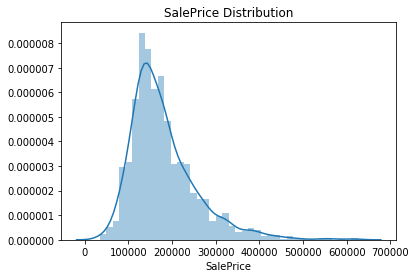

In [20]:
sns.distplot(data['SalePrice'])
plt.title('SalePrice Distribution')
plt.show()

After transforming the data we can see that the distribution of 'SalePrice' is no longer right skewed. We will also transform all features that exhibit skew greater than 0.5.

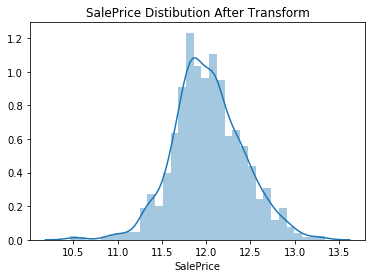

In [21]:
numeric_data = data.select_dtypes(include=[np.number])

# Quantify skew for all variables
skewed_table = abs(numeric_data.skew(axis = 0))

# If skew is > 0.5, then apply the log1p transform
skewed_numeric = skewed_table[skewed_table > 0.5].index
skewed_numeric_test = skewed_numeric.drop('SalePrice')

data[skewed_numeric] = np.log1p(data[skewed_numeric])
test[skewed_numeric_test] = np.log1p(test[skewed_numeric_test])

sns.distplot(data['SalePrice'])
plt.title('SalePrice Distibution After Transform')
plt.show()

The plots of categorical SalePrice - Categorical Feature show there are ordinal variables that have not been numerically coded. For all other categorical variables with no order we will dummy code each level into a separate feature.

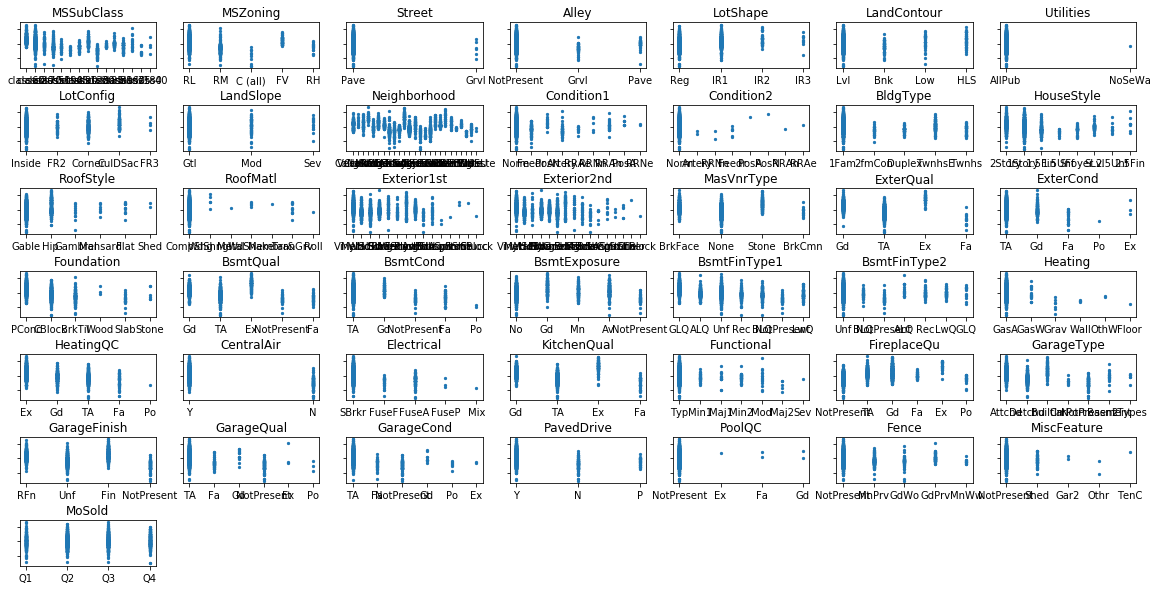

In [22]:
cat_data = data.select_dtypes(include=['object', 'category'])
cat_data['SalePrice'] = data['SalePrice'].copy()

f, ax = plt.subplots(7, 7, figsize=(20,10))
for row in range(7):
    for col in range(7):
        idx = col+(7*row)
        if idx < 44:
            x=cat_data.iloc[:, idx]
            y=cat_data['SalePrice']
            ax[row, col].scatter(x, y, s=5)
            ax[row, col].set_title(cat_data.columns[idx])
            ax[row, col].set_yticklabels([])
for i in range(6):
    f.delaxes(ax[6, i+1])
plt.subplots_adjust(hspace=0.8)
plt.show()

We will keep only the ordinal variables that exhibit some correlation with 'SalePrice', taken to be > 0.3. The features that do not meet the threshold will be dummy coded along with the rest of the remaining categorical features.

In [23]:
# List ordinal features according to their levels, ordinal_1 all share the same levels 
ordinal_1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_2 = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'Fence']
ordinal = ordinal_1 + ordinal_2

# Create a function to save repeating code
def ordinal_coding(df):
    ord_data = df[ordinal]
    for col in ordinal_1:
        try:
            ord_data.loc[ord_data[col] == 'Ex', col] = 5
            ord_data.loc[ord_data[col] == 'Gd', col] = 4
            ord_data.loc[ord_data[col] == 'TA', col] = 3
            ord_data.loc[ord_data[col] == 'Fa', col] = 2
            ord_data.loc[ord_data[col] == 'Po', col] = 1
            ord_data.loc[ord_data[col] == 'NotPresent', col] = 0
        except:
            pass

    ord_data.loc[ord_data['BsmtExposure'] == 'Gd','BsmtExposure'] = 4
    ord_data.loc[ord_data['BsmtExposure'] == 'Av','BsmtExposure'] = 3
    ord_data.loc[ord_data['BsmtExposure'] == 'Mn','BsmtExposure'] = 2
    ord_data.loc[ord_data['BsmtExposure'] == 'No','BsmtExposure'] = 1
    ord_data.loc[ord_data['BsmtExposure'] == 'NotPresent','BsmtExposure'] = 0

    ord_data.loc[ord_data['BsmtFinType1'] == 'GLQ','BsmtFinType1'] = 6
    ord_data.loc[ord_data['BsmtFinType1'] == 'ALQ','BsmtFinType1'] = 5
    ord_data.loc[ord_data['BsmtFinType1'] == 'BLQ','BsmtFinType1'] = 4
    ord_data.loc[ord_data['BsmtFinType1'] == 'Rec','BsmtFinType1'] = 3
    ord_data.loc[ord_data['BsmtFinType1'] == 'LwQ','BsmtFinType1'] = 2
    ord_data.loc[ord_data['BsmtFinType1'] == 'Unf','BsmtFinType1'] = 1
    ord_data.loc[ord_data['BsmtFinType1'] == 'NotPresent','BsmtFinType1'] = 0

    ord_data.loc[ord_data['BsmtFinType2'] == 'GLQ','BsmtFinType2'] = 6
    ord_data.loc[ord_data['BsmtFinType2'] == 'ALQ','BsmtFinType2'] = 5
    ord_data.loc[ord_data['BsmtFinType2'] == 'BLQ','BsmtFinType2'] = 4
    ord_data.loc[ord_data['BsmtFinType2'] == 'Rec','BsmtFinType2'] = 3
    ord_data.loc[ord_data['BsmtFinType2'] == 'LwQ','BsmtFinType2'] = 2
    ord_data.loc[ord_data['BsmtFinType2'] == 'Unf','BsmtFinType2'] = 1
    ord_data.loc[ord_data['BsmtFinType2'] == 'NotPresent','BsmtFinType2'] = 0

    ord_data.loc[ord_data['Functional'] == 'Typ','Functional'] = 7
    ord_data.loc[ord_data['Functional'] == 'Min1','Functional'] = 6
    ord_data.loc[ord_data['Functional'] == 'Min2','Functional'] = 5
    ord_data.loc[ord_data['Functional'] == 'Mod','Functional'] = 4
    ord_data.loc[ord_data['Functional'] == 'Maj1','Functional'] = 3
    ord_data.loc[ord_data['Functional'] == 'Maj2','Functional'] = 2
    ord_data.loc[ord_data['Functional'] == 'Sev','Functional'] = 1
    # ord_data.loc[ord_data['Functional'] == 'Sal','Functional'] = 0  # This level is missing from both train and test 

    ord_data.loc[ord_data['GarageFinish'] == 'Fin','GarageFinish'] = 3
    ord_data.loc[ord_data['GarageFinish'] == 'RFn','GarageFinish'] = 2
    ord_data.loc[ord_data['GarageFinish'] == 'Unf','GarageFinish'] = 1
    ord_data.loc[ord_data['GarageFinish'] == 'NotPresent','GarageFinish'] = 0

    ord_data.loc[ord_data['Fence'] == 'GdPrv','Fence'] = 4
    ord_data.loc[ord_data['Fence'] == 'MnPrv','Fence'] = 3
    ord_data.loc[ord_data['Fence'] == 'GdWo','Fence'] = 2
    ord_data.loc[ord_data['Fence'] == 'MnWw','Fence'] = 1
    ord_data.loc[ord_data['Fence'] == 'NotPresent','Fence'] = 0
    return ord_data


ord_data = ordinal_coding(data)
test_ord_data = ordinal_coding(test)

# Obtain the correlation for each ordinal variable, and keep only those with correlation > 0.3
ord_data['SalePrice'] = data['SalePrice'].copy()
ordinal_corr_dict = {}
for col in ordinal:
    ordinal_corr_dict[col] = ord_data[col].corr(ord_data['SalePrice'])
    
ordinal_keep =  [k for k,v in ordinal_corr_dict.items() if abs(v) >= 0.3]

# Implement numeric coding of ordinal features
data[ordinal_keep] = ord_data[ordinal_keep]
test[ordinal_keep] = test_ord_data[ordinal_keep]

Now that the ordinal features have been converted to a numeric data type, we can start considering interactions between numeric features.

Our data set has 37 numerical features, which means there will be 666 second order interaction terms added to our dataset. In order to prevent overfitting we must select only the most important interactions. Several machine learning models have implicit features selection such as lasso regression which utilizes L1 regularization to select features, and gradient boosting which can rank feature importance by calculating the improvement to the model if the feature is added.

Feature selection was performed after all categorical variables were dummy coded, however the 15 highest lasso coefficients after normalization, and the 15 highest ranked gradient boosted features are seen below. The set of these interactions were used in the final model. The the number of interactions to include can be optimized to improve model performance even further.

In [24]:
# Select numeric data without quadratic columns
numeric_data = data.select_dtypes(include=[np.number])
numeric_data = numeric_data.drop(columns=['SalePrice'])
numeric_data = numeric_data.drop(columns=quadratic_columns)

# Select only top 15 interactions from lasso and xgboost feature selection methods
interactions_lasso = ['OverallQual:OverallCond', 'GrLivArea:TotalSF', 'LotArea:GrLivArea', 'OverallCond:ExterQual', 'ExterQual:Fireplaces', 'OverallCond:TotalSF', 'KitchenQual:TotalBaths', 'OverallQual:TotalBaths', '1stFlrSF:GrLivArea', 'KitchenQual:GarageCond', 'OverallQual:GarageQual', 'KitchenAbvGr:AgeSold', 'HeatingQC:TotalBaths', 'BsmtQual:TotalBaths', 'BsmtExposure:FireplaceQu']
interactions_xgboost = ['OverallCond:TotalSF', 'OverallCond:AgeSold', 'ExterQual:AgeSold', 'LotArea:OverallCond', 'LotArea:GrLivArea', '1stFlrSF:AgeSold', 'OverallCond:TotalSF', 'LotFrontage:ScreenPorch', 'BsmtQual:OpenPorchSF', '1stFlrSF:GrLivArea', 'TotalBaths:AgeSold', 'OverallCond:GrLivArea', 'BsmtFinType1:BsmtFinSF1', 'HeatingQC:TotalSF', 'LotArea:TotalSF']
interactions = list(set(interactions_lasso) | set(interactions_xgboost))

# Add interaction terms
for i in range(len(numeric_data.columns)):
    i_col = numeric_data.columns[i]
    for j in range(i + 1, len(numeric_data.columns)):
        j_col = numeric_data.columns[j]
        col_name = str(numeric_data.columns[i]) + ':' + numeric_data.columns[j]
        data[col_name] = data[i_col] * data[j_col]
        test[col_name] = test[i_col] * test[j_col]
        if col_name not in interactions:
            data = data.drop(columns=col_name)
            test = test.drop(columns=col_name)

            
            

We can now dummy code the remaining categorical columns.

In [25]:
# Identify non-ordinal categorical columns
cat_cols = [col for col in cat_data.columns if col not in ordinal_keep]
cat_cols.remove('SalePrice')

dummy_df = pd.get_dummies(data[cat_cols])
test_dummy_df = pd.get_dummies(test[cat_cols])

data = pd.concat([data, dummy_df], axis=1)
test = pd.concat([test, test_dummy_df], axis=1)

data = data.drop(columns=cat_cols, axis=1)
test = test.drop(columns=cat_cols, axis=1)

# The train and test columns do not have the same levels so we create columns for missing levels to maintain dimensionality
missing_cols = set(data.columns) - set(test.columns)
for col in missing_cols:
    test[col] = 0

test = test[data.columns]
test = test.drop(columns=['SalePrice'])


Previously we transformed many features in an effort to reduce skew. After further analysis many features still exhibit high levels of skew to the large number of zero values if the feature is not present.

For example, consider 'MasVnrArea' - Masonry Veneer Area. The distribution of values is highly skewed since properties without this feature are set a value of 0. We can attempt to mitigate the effect of the zero-skew by adding additional dummy values that indicate whether the feature is zero or not. 

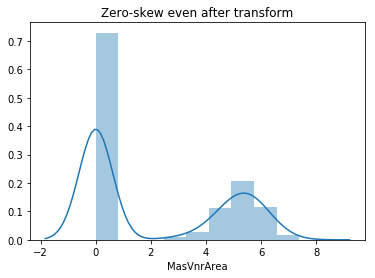

In [26]:
sns.distplot(data['MasVnrArea'])
plt.title('Zero-skew even after transform')
plt.show()

# Add dummy cols to reduce zero-skew in numeric columns 
zero_dummy_cols = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'GarageArea**2', 'MasVnrArea**2', 'BsmtFinSF1**2','OpenPorchSF**2','TotalBsmtSF**2','WoodDeckSF**2']
for col in zero_dummy_cols:
    data['NonZero' + col] = (data[col] > 0).astype(int)
    test['NonZero' + col] = (test[col] > 0).astype(int)

After feature engineering we have a final count of 317 columns. As the goal of this project is to create a predictive model as opposed to an inferential model, we will go ahead and utilize all the features in models such as Ridge Regression.

In [27]:
# Final dataset has 317 columns
print(data.shape)

(1456, 336)


# Modelling

Ridge regression, Elastic net regression and gradient boosting are the three models that will be investigated. Hyperparameters are optimzied via grid search five fold cross valdidation. While the scoring method of the competition is RMSLE, negative RMSE will be used as a substitute that is available the sk-learn module.

After fitting and elastic net model we see that the residual plot has many potential outliers in the plot. The best course of action would be to scrutinize the source of the data to determine if these data points are real or not. For now we will remove points with a residual greater than 0.35 (corresponding to a studentized residual greater than 3) and we will replot the model.

-0.014971109789379836


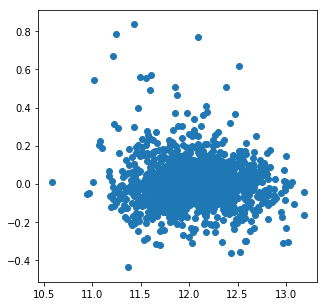

In [28]:
# Fit Elastic net model
import warnings
warnings.filterwarnings("ignore")

Y = data['SalePrice']
X = data.drop(columns=['SalePrice'])


en_model = ElasticNet(normalize=False)

# To save computation time, optimized hyperparameters are provided

"""
params = {'alpha': np.linspace(0.0008, 0.0012, 3),
          'l1_ratio': np.linspace(0.58, 0.66, 4)}
"""

params = {'alpha': [0.01], 'l1_ratio': [0.63]}

grid = GridSearchCV(en_model, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)
best_params = grid.best_params_
best_score = grid.best_score_
best_knn = grid.best_estimator_
print(best_score)
en_coefs = pd.Series(grid.best_estimator_.coef_,index=X.columns)

y_pred_en = grid.best_estimator_.predict(X)

# Plot residuals
residuals_train = y_pred_en - Y
data['residual'] = residuals_train


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.scatter(y_pred_en, residuals_train)
plt.show()


After removing the potential outliers we see that the residual plot is randomly distributed, and the negative RMSE has improved substantially from -0.01497 to -0.00827.

-0.008273148071061717


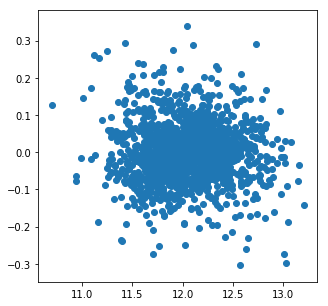

In [29]:
data = data[abs(data['residual'])< 0.35]

Y = data['SalePrice']
X = data.drop(columns=['SalePrice', 'residual'])

en_model = ElasticNet(normalize=False)

"""
params = {'alpha': np.linspace(0.0002, 0.0020, 10),
          'l1_ratio': np.linspace(0.1, 0.5, 10)}
"""

params = {'alpha': [0.0008], 'l1_ratio': [0.36]}

grid = GridSearchCV(en_model, params, cv=5, scoring='neg_mean_squared_error')
grid.fit(X, Y)
best_params = grid.best_params_
best_score = grid.best_score_
best_knn = grid.best_estimator_
print(best_score)
en_coefs = pd.Series(grid.best_estimator_.coef_,index=X.columns)

y_pred_en = grid.best_estimator_.predict(X)

# Plot residuals
residuals_train = y_pred_en - Y
data['residual'] = residuals_train


fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.scatter(y_pred_en, residuals_train)
plt.show()

# Discussion and Future Work

The results for all methods are summarized in the following table:

| Score        | Baseline OLS | Elastic Net | Ridge    | Lasso    | XGBoost | 
|--------------|--------------|-------------|----------|----------|---------| 
| CV neg RMSE      | -0.0156      | -0.00827    | -0.00913 | -0.00863 | -0.013  | 
| Kaggle RMLSE | 0.14048      | 0.11501     | 0.11548  | 0.11578  | 0.12755 | 

From the baseline OLS model with no feature engineering we are able to improve the RMLSE from 0.14048 to 0.11501.

The biggest improvements in model performance came from feature engineering. With numeric ordinal feature coding, 'LotFrontage' linear imputation, and polynomial terms the RMSLE improved to 0.12001. With new feature creation and residual outlier removal a score of 0.11833 could be achieved. Finally, with the addition of second order interaction terms we obtain the final scores seen in the table.

The Elastic Net CV RMSE is the lowest of all models, and correspondingly, the RMSLE of the kaggle holdout set is minimized. The fact that Elastic Net outperformed Ridge and Lasso intuitvely makes sense as Elastic Net combines the L1 and L2 regularization terms found in Lasso and Ridge respectively so in effect Elastic Net is combining the strengths of both models.

We see that the CV RMSE for XGBoost is 50% higher than the other methods, and performance on the holdout set is poor. The underrfitting of XGBoost would likely be reduced by further hyperparameter optimization. For the sake of computation time some parameters such as n_estimators, reg_alpha and learning_rate were kept constant. By performing a grid search over these parameters would likely improve this score. In order to tackle the computation time issue, Bayesian Optimization methods could be employed.

Further improvements to the model can be achieved via optimization of the number of second-order interaction terms, further hyper-parameter optimization of XGBoost, troubleshooting of the LotFrontage imputation residual plot, and the testing of models not used in this project such as SVM, neural networks and model ensembling.

In terms of the most important features, we can directly compare coefficients from the elastic net model as long as the features are standardized. It was observed that standardization had a lower Kaggle RMSLE than non-standardized data, so standardization was not used in the final model, however for the sake of comparison, the features in the table below are the 15 highest coefficients obtained after standardization of the numerical features and their interactions. 

| Feature                 | Feature Description                                  | Data type   | Standardized Coefficient | 
|-------------------------|------------------------------------------------------|-------------|--------------------------| 
| Neighborhood_StoneBr    | Stonebrook Neighborhood                              | Categorical | 0.092412                 | 
| Neighborhood_Crawfor    | Crawford Neighborhood                                | Categorical | 0.091948                 | 
| MSZoning_C (all)        | Commercial Zoning                                    | Categorical | -0.091261                | 
| Exterior1st_BrkFace     | Brick Face Exterior                                  | Categorical | 0.07494                  | 
| 1stFlrSF:AgeSold        | First floor SF:Age of property interaction           | Numerical   | -0.058784                | 
| Functional_Typ          | Typical Home Functionality                           | Categorical | 0.05756                  | 
| GrLivArea:TotalSF       | Above Ground SF:Total SF interaction                 | Numerical   | 0.055575                 | 
| Neighborhood_NoRidge    | Northridge Neighborhood                              | Categorical | 0.053492                 | 
| LotArea:GrLivArea       | Lot size: Above Ground SF interaction                | Numerical   | 0.050225                 | 
| Functional_Maj2         | Major Deductions 2' Functionality                    | Categorical | -0.048467                | 
| TotalSF                 | Above Ground SF + Basement SF                        | Numerical   | 0.044119                 | 
| OverallQual:OverallCond | Overall finish quality:Overall condition interaction | Numerical   | 0.044103                 | 
| Neighborhood_Edwards    | Edwards Neighborhood                                 | Categorical | -0.042163                | 
| MSZoning_RM             | Medium Density Residential Zoning                    | Categorical | -0.041398                | 
| SaleCondition_Abnorml   | Abnormal Sale Condition (trade/foreclosure)          | Categorical | -0.03913                 | 
 

It can be seen that the most influential features are generally those related to the neighborhood location and the size of the property. In terms of categorical variables a house residing in the Stonebrook and Crawford  neighborhoods have the highest influence on price. A house in a commerical zone has a large negative effect on the price, and interestingly, a house possessing a brick face exterior has a huge advantage over all other exteriors such as wood, metal or stone. 

In terms of numerical categories there are no suprises, with larger, newly built properties having the highest value. Three out of the four numerical features are interactions, which explains an observation that the Kaggle holdout RMLSE score improved dramatically from 0.120 to 0.115 when including second order interactions.